# Introduction to Grad-CAM Analysis with TockyConvNetPy: Analysis Workflow Using The CNS2 KO Foxp3-Tocky Data

Author: Masahiro Ono

Date: 2025-02-19

Welcome to our Jupyter notebook where we explore the application of Gradient-weighted Class Activation Mapping (Grad-CAM) using the `TockyConvNetPy` package. This analysis aims to provide insights into how different convolutional layers in our neural network model contribute to decisions made by the model, particularly in classifying and understanding complex image data.

### Purpose of This Notebook

- **Visualize Influential Regions:** Through Grad-CAM, we visualize the regions in the input images that are important for making predictions, which helps in understanding model behavior.
- **Layer-by-Layer Analysis:** We analyze the influence of each convolutional layer to see how each one processes and transforms the input data to extract meaningful features.
- **Model Assessment:** By examining the activation maps, we can assess whether the model is focusing on relevant parts of the images for making correct classifications, which is crucial for tasks such as medical imaging, object detection in autonomous vehicles, and more.

### Model Overview

The model used in this analysis is a convolutional neural network (ConvNet or CNN) that has been trained to classify images based on specific features learned during training. Below is a brief overview of the model architecture, highlighting the layers that will be analyzed:

- **`conv2d`**: The first convolutional layer, applying initial filters to capture basic image features like edges.
- **`conv2d_1`**: Follows `conv2d`, aimed at refining the features by applying a spatial attention mechanism.
- **`conv2d_2`**: Starts the second block of convolution, processing deeper features.
- **`conv2d_3`**: Similar to `conv2d_1`, it refines features for the second block.

This notebook will guide you through loading the model, processing images, and visualizing the Grad-CAM heatmaps for these layers. We will also evaluate the model's performance on a set of test images and discuss the results.

### Getting Started

To begin, ensure that the `TockyConvNetPy` package is installed in your environment. This package includes the pre-trained model and utilities necessary for generating and visualizing Grad-CAM heatmaps. 

In the current workflow, a pre-trained model will be loaded and used for Grad-CAM analysis.


## **Evaluating the TockyConvNet Model on an Independent Test Dataset**

In this section, we assess the performance of the **TockyConvNet** model using an independent test dataset. The goal is to quantify the model's predictive capabilities and visualize its classification performance using **Receiver Operating Characteristic (ROC) curves** and **Precision-Recall (PR) curves**.

### **Steps in This Analysis**
1. **Load the Independent Test Data**  
   - Load test images and labels stored in `data/dataset_CNS2/test_data/`.
   - Extract the ground-truth class labels from the one-hot encoded format.

2. **Model Predictions & Threshold Optimization**  
   - Use the trained model to generate class probabilities for each test image.
   - Compute the **ROC curve** and determine the **optimal threshold** for classification using the **geometric mean (G-mean)** method.

3. **Performance Metrics Calculation**  
   - Generate a **confusion matrix** to assess classification performance.
   - Compute key **metrics**, including:
     - **Accuracy**
     - **Sensitivity (Recall)**
     - **Specificity**
     - **ROC-AUC score**

4. **Visualizing Model Performance**  
   - Plot the **ROC curve** to illustrate the trade-off between sensitivity and specificity.
   - Generate the **Precision-Recall (PR) curve** to evaluate performance in handling class imbalances.

The following code implements these steps, providing a detailed breakdown of the model’s effectiveness in classifying test images.


In [1]:
import importlib.resources
from tensorflow.keras.models import load_model

with importlib.resources.path("TockyConvNetPy.data.Foxp3CNS2.models", "CNS2Foxp3Tocky_trained_model.keras") as model_path:
    model = load_model(str(model_path))

In [2]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 100, 100, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2/2 [==============================] - 0s 18ms/step
Confusion Matrix:
[[27  0]
 [ 0 22]]
Specificity: 1.00
Sensitivity: 1.00
Accuracy: 100.00%


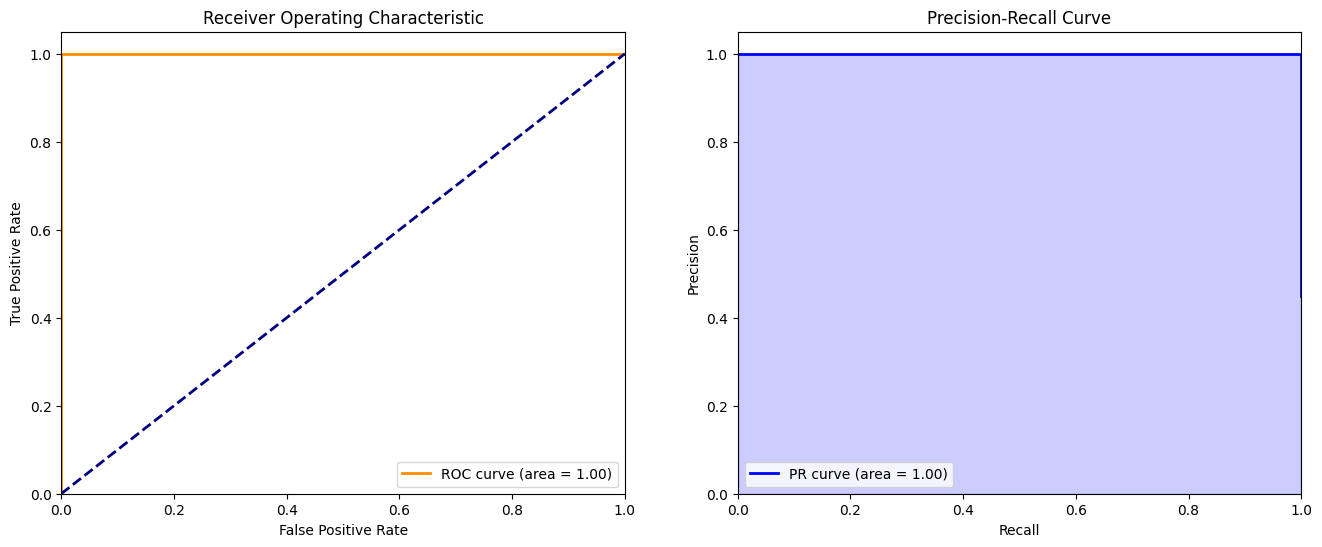

In [5]:
#Test Images From Independent Test Dataset
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from TockyConvNetPy import find_optimal_threshold
import importlib.resources

with importlib.resources.path("TockyConvNetPy.data.Foxp3CNS2.test_data", "sample_images.npy") as images_path:
    with importlib.resources.path("TockyConvNetPy.data.Foxp3CNS2.test_data", "sample_labels.npy") as labels_path:
        images_path = str(images_path)
        labels_path = str(labels_path)

sample_images = np.load(images_path)
sample_labels = np.load(labels_path)
true_classes = np.argmax(sample_labels, axis=1)

# Make predictions and Compute ROC and PR curves
probabilities = model.predict(sample_images)
positive_class_probabilities = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(true_classes, positive_class_probabilities)
roc_auc = roc_auc_score(true_classes, positive_class_probabilities)

optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
predicted_classes = (probabilities[:, 1] >= optimal_threshold).astype(int)
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Specificity and Sensitivity
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
print(f"Specificity: {specificity:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
acc = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {acc*100:.2f}%")

# Plotting ROC and PR curves
precision, recall, _ = precision_recall_curve(true_classes, positive_class_probabilities)
average_precision = average_precision_score(true_classes, positive_class_probabilities)

plt.figure(figsize=(16, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Grad-CAM Analysis of Convolutional Layers

This section details the Grad-CAM analysis performed on the different convolutional layers within our model. Grad-CAM allows us to visualize which areas of the input image are important for predicting the model's output by highlighting the most influential regions in each convolutional layer.

### Analyzed Layers

- **`conv2d`:** This is the first convolutional layer in our model. It applies 16 filters of size 3x3 to the input image, preserving the spatial dimensions (100x100), and is crucial for initial feature extraction such as edges and textures.

- **`conv2d_1`:** Positioned right after `conv2d`, this layer implements spatial attention using a 1x1 convolution that outputs a single channel feature map. This map, through a sigmoid activation function, creates an attention mask that helps the model focus on relevant parts of the input in subsequent layers.

- **`conv2d_2`:** This layer marks the beginning of the second convolutional block. Similar to `conv2d`, it further processes the features reduced in dimensionality by previous pooling layers, applying additional 16 filters to capture more complex patterns.

- **`conv2d_3`:** Mirroring the function of `conv2d_1`, this layer applies a 1x1 convolution to generate a single channel spatial attention map within the second convolutional block. It focuses the model's learning on specific areas, improving the interpretability and effectiveness of the model.

Each of these layers contributes uniquely to the model’s ability to accurately classify images by focusing on different types of features, from basic edges to more complex textural information.

# Analysis Overview

The following part analyses each of the convolutional layers of the TockyCNN model using Grad-CAM. Our goal is to identify which features are most influential in determining the output of the model and how different layers contribute to the decision-making process.

## Steps:
1. Load the model and display its summary.
2. Process sample images through the model.
3. Generate and visualize Grad-CAM heatmaps for each layer.

2/2 [==============================] - 0s 18ms/step
Grad-CAM Analysis of conv2d


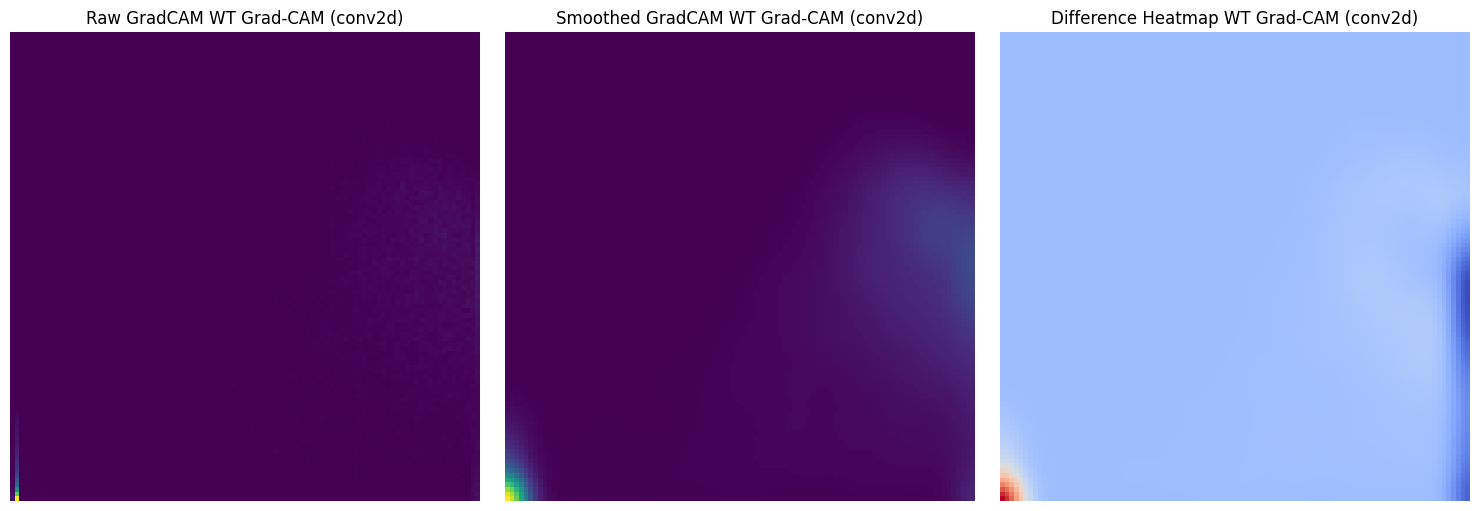

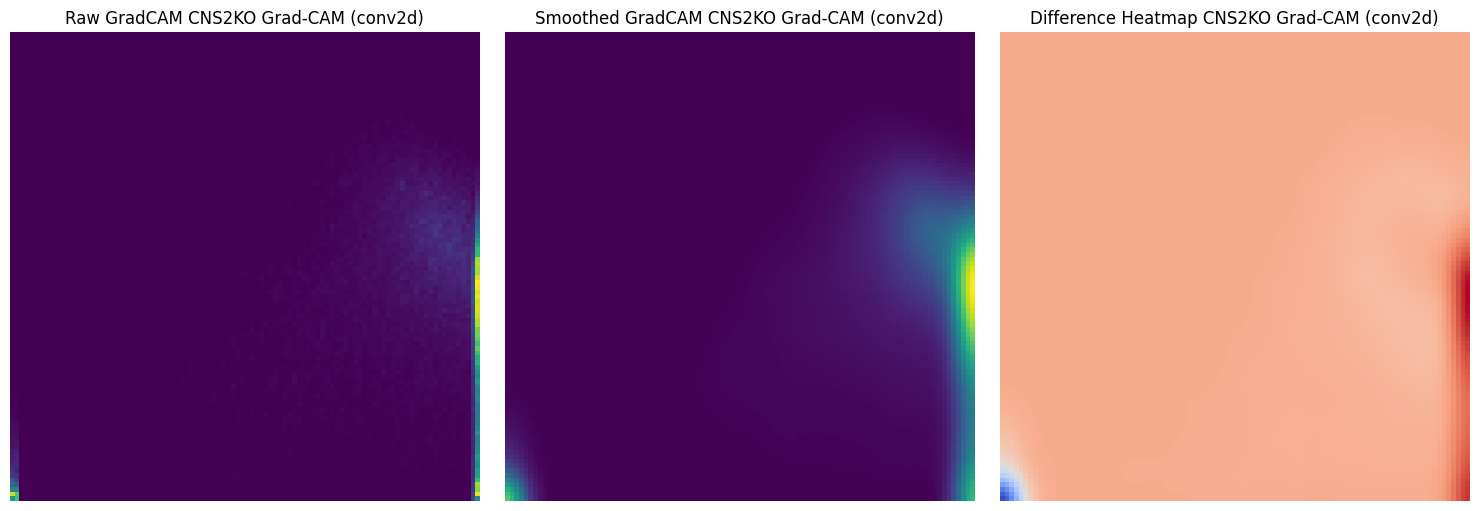

2/2 [==============================] - 0s 15ms/step
Grad-CAM Analysis of conv2d_1


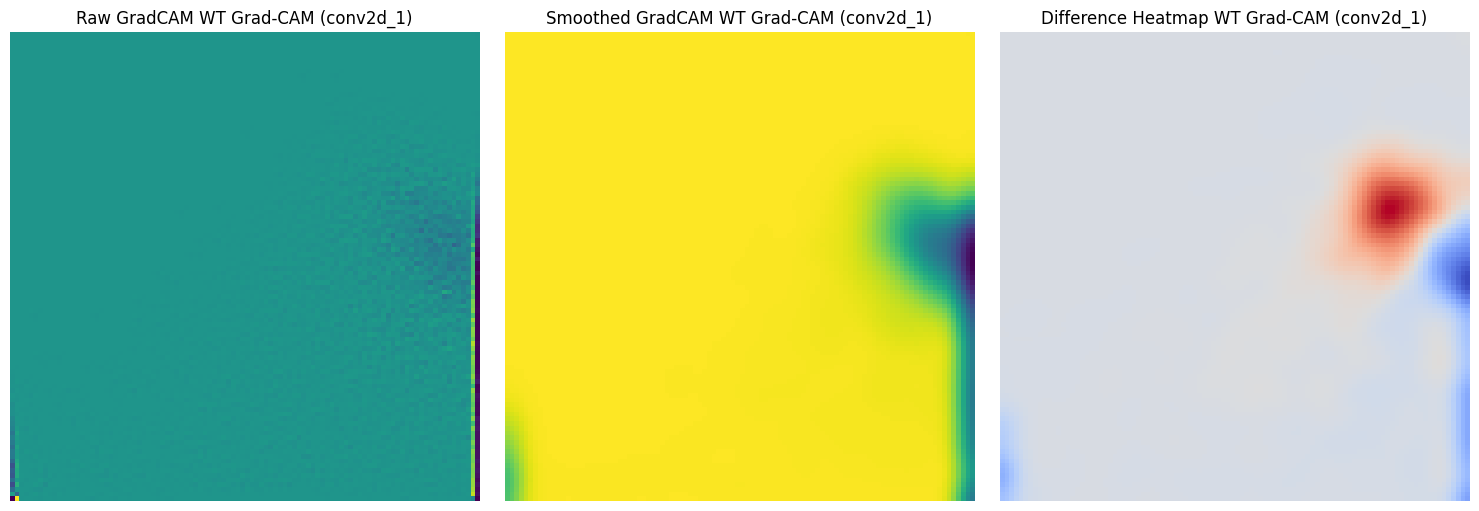

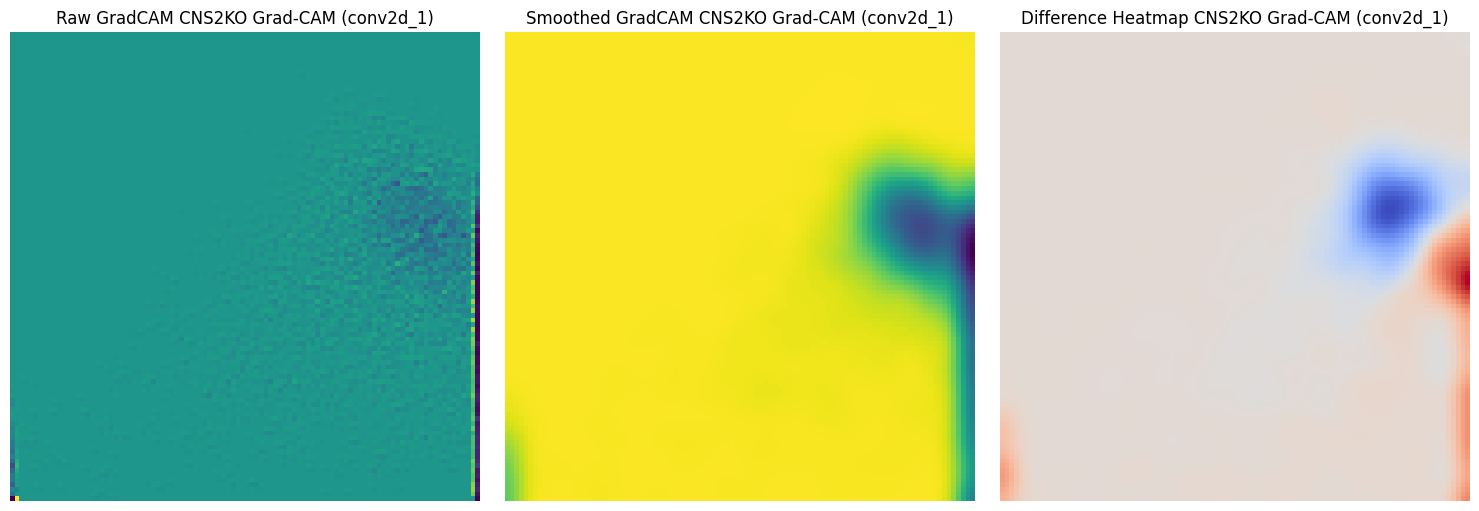

2/2 [==============================] - 0s 17ms/step
Grad-CAM Analysis of conv2d_2


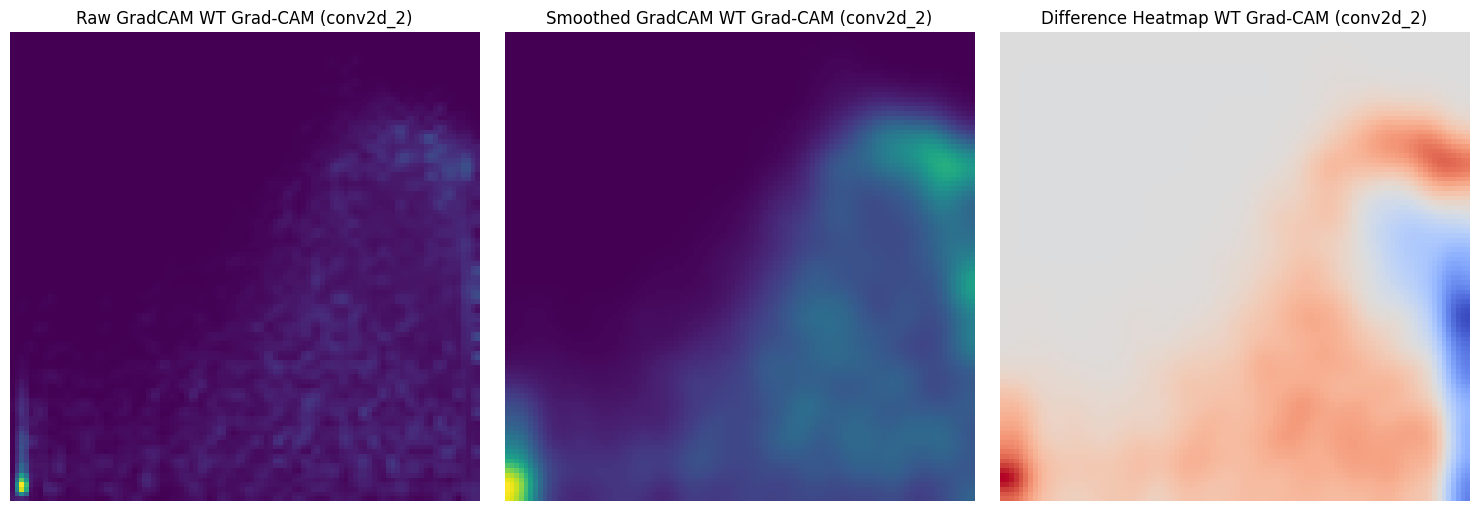

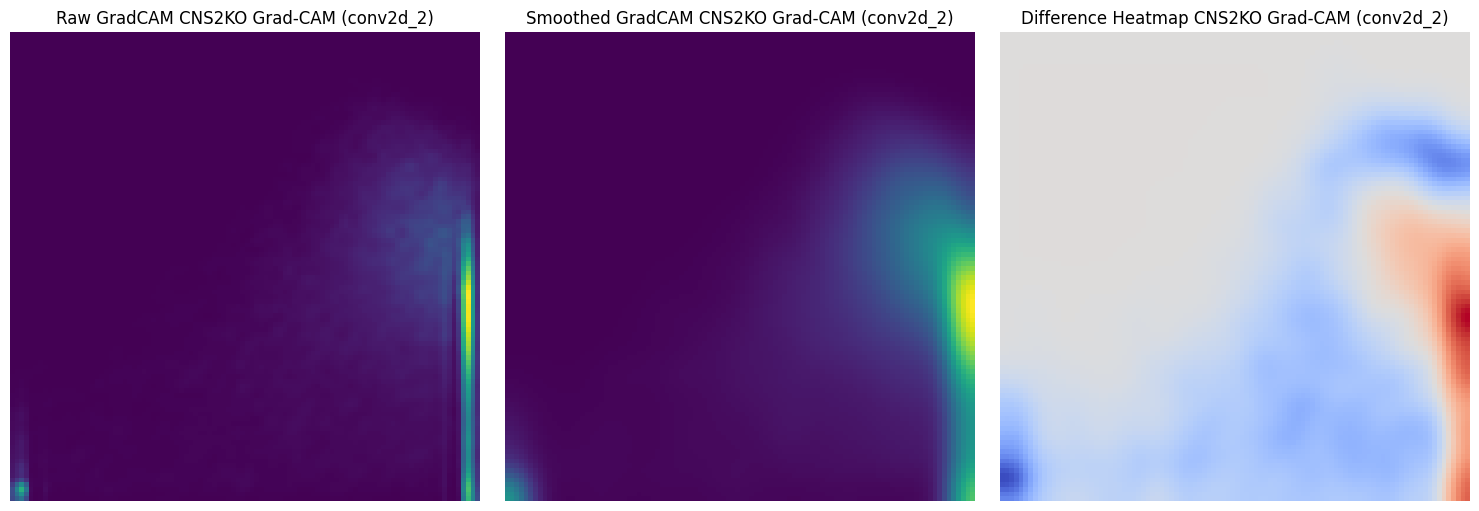

2/2 [==============================] - 0s 19ms/step
Grad-CAM Analysis of conv2d_3


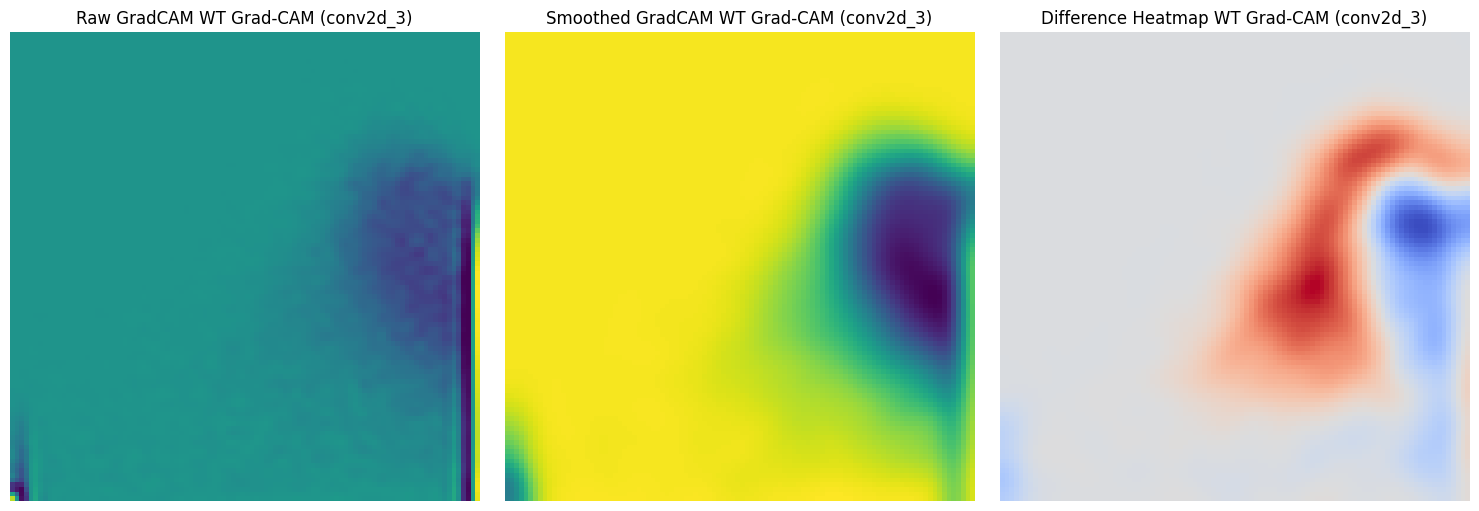

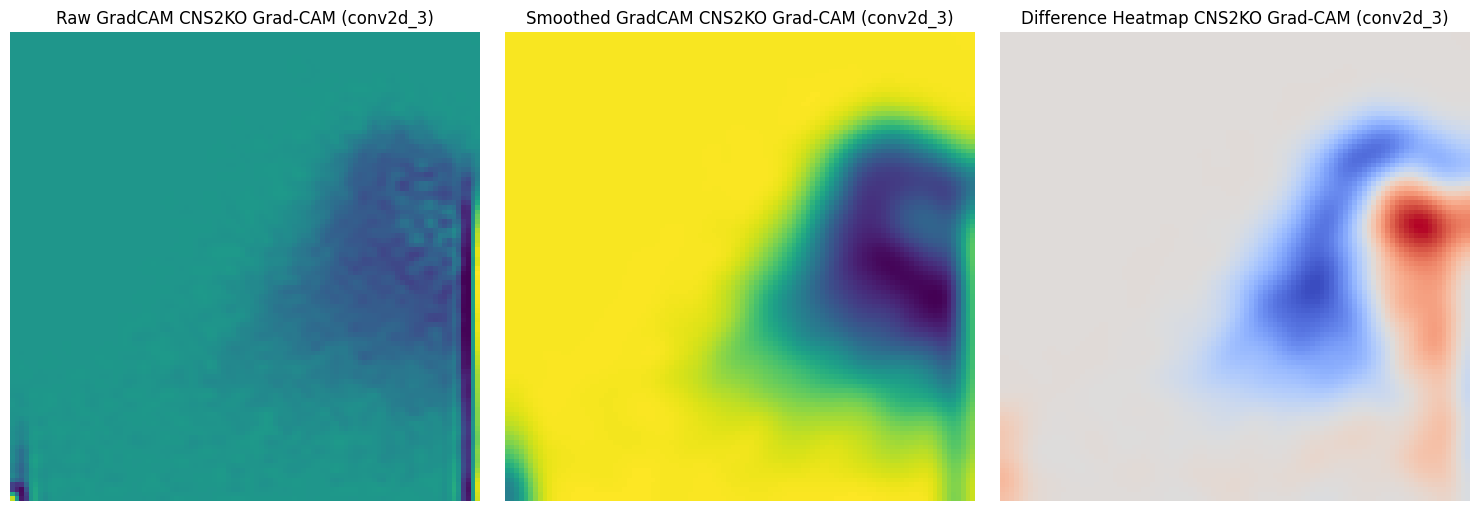

In [6]:
from TockyConvNetPy import find_optimal_threshold, generate_aggregated_heatmap, smooth_heatmap, visualize_heatmaps

layer_names = ["conv2d", "conv2d_1", "conv2d_2", "conv2d_3"]

for layer in layer_names:
    probabilities = model.predict(sample_images)
    WT_class_probabilities = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(true_classes, WT_class_probabilities)
    optimal_threshold_WT = find_optimal_threshold(fpr, tpr, thresholds)

    KO_class_probabilities = probabilities[:, 0]
    fpr, tpr, thresholds = roc_curve(true_classes, KO_class_probabilities)
    optimal_threshold_KO = find_optimal_threshold(fpr, tpr, thresholds)

    WT_aggregated_heatmap = generate_aggregated_heatmap(sample_images, model, layer, optimal_threshold_WT, 1)
    CNS2KO_aggregated_heatmap = generate_aggregated_heatmap(sample_images, model, layer, optimal_threshold_KO, 0)

    WT_smoothed_heatmap = smooth_heatmap(WT_aggregated_heatmap, sigma=3)
    CNS2KO_smoothed_heatmap = smooth_heatmap(CNS2KO_aggregated_heatmap, sigma=3)
    heatmap_difference = WT_smoothed_heatmap - CNS2KO_smoothed_heatmap

    print(f"Grad-CAM Analysis of {layer}")

    visualize_heatmaps(WT_aggregated_heatmap, WT_smoothed_heatmap, heatmap_difference, f"WT Grad-CAM ({layer})")
    visualize_heatmaps(CNS2KO_aggregated_heatmap, CNS2KO_smoothed_heatmap, -heatmap_difference, f"CNS2KO Grad-CAM ({layer})")


## **Generating Grad-CAM Heatmaps for Downstream Analysis in TockyConvNetR**

This section applies **Grad-CAM** to visualize the most influential regions of input images that contribute to classification decisions made by the **TockyConvNet** model. Specifically, we focus on **`conv2d_3`**, the final convolutional layer, as it captures high-level feature representations crucial for classification. 

The generated **Grad-CAM heatmaps** will be exported as CSV files and stored as **example datasets** in the **`inst/extdata`** directory of the **TockyConvNetR** package. These files will facilitate **R-based downstream analysis**, including visualization, statistical comparisons, and spatial feature extraction.

---

### **Workflow Overview**
1. **Select the Last Convolutional Layer (`conv2d_3`)**  
   - This layer is chosen as it represents the **final spatial feature map** before the fully connected layers.  
   - Grad-CAM applied at this stage highlights **discriminative image regions** for each class (WT vs KO).  

2. **Compute Class Probabilities & Determine Optimal Thresholds**  
   - Model predictions are obtained for both **WT** and **KO** samples.  
   - The **ROC curve** is used to determine the **optimal classification threshold** for each class.

3. **Generate & Process Grad-CAM Heatmaps**  
   - **Grad-CAM heatmaps** are computed for WT and KO sample sets.  
   - These heatmaps are **Gaussian-smoothed** to reduce noise and enhance spatial coherence.  
   - The **difference heatmap** between WT and KO is calculated for comparative analysis.

4. **Export Processed Heatmaps to CSV**  
   - The **heatmap difference matrix** is saved in CSV format.  
   - These CSV files are included in **`inst/extdata`** of the **TockyConvNetR** package, allowing users to load them via R functions.  
   - The exported data serves as **example datasets** for spatial and statistical analyses within R.

---

### **Note:**
Using **Grad-CAM** at `conv2d_3`, we extract interpretable **spatial activation patterns** from deep learning models. The resulting heatmap data are indeed the one stored in **TockyConvNetR as an example heatmap data**.


In [7]:
# Optional: Save results to CSV

#from TockyConvNetPy find_optimal_threshold, generate_aggregated_heatmap, smooth_heatmap visualize_heatmaps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from skimage import exposure
import matplotlib.colors as mcolors

# Setup
conv_layer = "conv2d_3" 

# Calculate probabilities and thresholds
probabilities = model.predict(sample_images)
WT_class_probabilities = probabilities[:, 1]
fpr, tpr, thresholds = roc_curve(true_classes, WT_class_probabilities)
optimal_threshold_WT = find_optimal_threshold(fpr, tpr, thresholds)

KO_class_probabilities = probabilities[:, 0]
fpr, tpr, thresholds = roc_curve(true_classes, KO_class_probabilities)
optimal_threshold_KO = find_optimal_threshold(fpr, tpr, thresholds)

WT_aggregated_heatmap = generate_aggregated_heatmap(sample_images, model, conv_layer, optimal_threshold_WT, 1)
CNS2KO_aggregated_heatmap = generate_aggregated_heatmap(sample_images, model, conv_layer,  optimal_threshold_KO, 0)

WT_smoothed_heatmap = smooth_heatmap(WT_aggregated_heatmap, sigma=3)
CNS2KO_smoothed_heatmap = smooth_heatmap(CNS2KO_aggregated_heatmap, sigma=3)
heatmap_difference = WT_smoothed_heatmap - CNS2KO_smoothed_heatmap

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    csv_path = os.path.join(conv_layer, filename)
    df.to_csv(csv_path, index=False)

if not os.path.exists(conv_layer):
    os.makedirs(conv_layer)

save_to_csv(heatmap_difference, 'heatmap_difference.csv')

2/2 [==============================] - 0s 18ms/step
